In [3]:
%pip install scikit-learn

  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   ------ --------------------------------- 1.3/8.1 MB 5.2 MB/s eta 0:00:02
   ----------- ---------------------------- 2.4/8.1 MB 5.0 MB/s eta 0:00:02
   ---------------- ----------------------- 3.4/8.1 MB 5.0 MB/s eta 0:00:01
   -------------------- ------------------- 4.2/8.1 MB 4.8 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.1 MB 4.8 MB/s eta 0:00:01
   ------------------------------- -------- 6.3/8.1 MB 4.9 MB/s eta 0:00:01
   ------------------------------------ --- 7.3/8.1 MB 4.9 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 4.7 MB/s  0:00:01
Using cached joblib-1.5.3-py3-none-any.whl (309 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   -----------

TECHNIQUE -1

In [4]:
import h5py
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import pandas as pd
import os

In [5]:
def get_ml_mask(image):
    # Flatten image for K-Means
    pixels = image.reshape(-1, 1)
    # Using 3 clusters: Dark background, Gray matter, Bright tumor
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=0).fit(pixels)
    
    # The cluster with the highest intensity mean is the tumor
    tumor_cluster = np.argmax(kmeans.cluster_centers_)
    mask = (kmeans.labels_ == tumor_cluster).reshape(image.shape)
    
    # Clean up the mask using morphological operations
    mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, np.ones((3,3)))
    return mask

In [6]:
def build_qvpr_circuit(image, mask):
    n = int(np.log2(image.shape[0]))
    # 2n position qubits + 8 color qubits + 1 control qubit
    qc = QuantumCircuit(2*n + 9)
    
    # Superposition for all coordinates
    qc.h(range(2*n))
    
    # Apply logic based on ML mask
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            if mask[y, x] == 1:
                # ROI Detected: Use High Precision (NEQR logic)
                for i in range(8):
                    qc.cx(0, 2*n + i)
            else:
                # Background: Use Low Precision (FRQI logic)
                qc.ry(np.pi/4, 2*n + 8)
    return qc

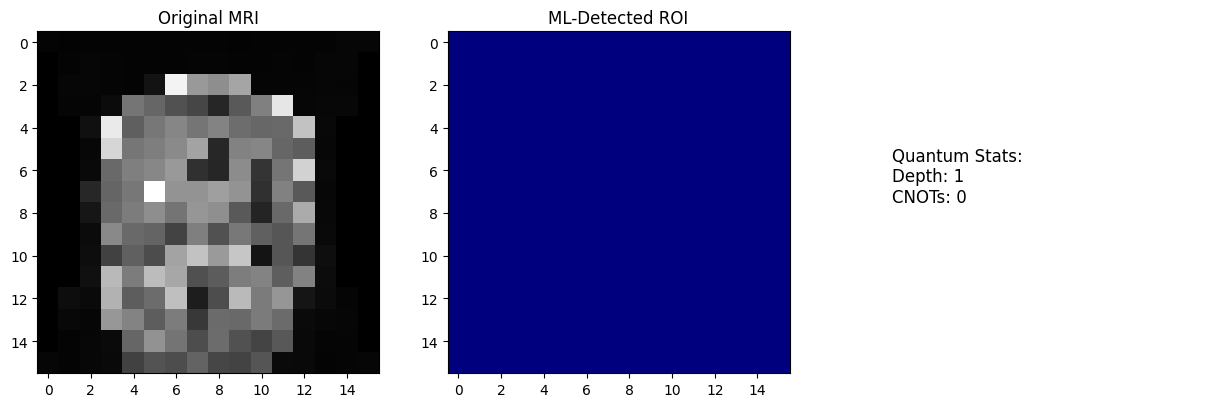

In [7]:
# Configuration
FILE_PATH = r'C:\Users\sagar\Downloads\quantum_image_representaion\data\768.mat' # Example file
SIZE = 16

# 1. Load and Preprocess
with h5py.File(FILE_PATH, 'r') as f:
    img = np.array(f['cjdata']['image']).T
    img = cv2.resize(img, (SIZE, SIZE))
    img = (img - img.min()) / (img.max() - img.min() + 1e-6)

# 2. Run ML Segmentation
mask = get_ml_mask(img)

# 3. Generate Quantum Circuit
qc = build_qvpr_circuit(img, mask)
t_qc = transpile(qc, basis_gates=['u', 'cx'], optimization_level=3)

# 4. Display Results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title("Original MRI")
ax[1].imshow(mask, cmap='jet')
ax[1].set_title("ML-Detected ROI")
ax[2].text(0.1, 0.5, f"Quantum Stats:\nDepth: {t_qc.depth()}\nCNOTs: {t_qc.count_ops().get('cx', 0)}", fontsize=12)
ax[2].axis('off')
plt.show()

TECHNIQUE - 2

In [8]:
import os
import h5py
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# Paths - Ensure these match your local folders
BASE_PATH = r'C:\Users\sagar\Downloads\quantum_image_representaion'
DATA_DIR = os.path.join(BASE_PATH, 'data')
OUTPUT_DIR = os.path.join(BASE_PATH, 'outputs')
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Libraries and Paths Ready.")

Libraries and Paths Ready.


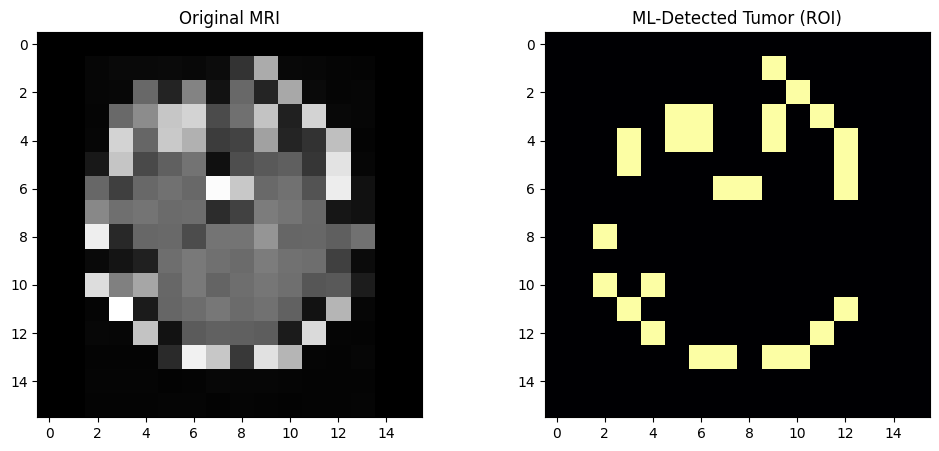

Results for QVPR Technique:
- Quantum Circuit Depth: 8
- Optimized CNOT Count: 8


In [9]:
def run_hybrid_ml_quantum(file_name, size=16):
    path = os.path.join(DATA_DIR, file_name)
    
    # 1. Classical Layer: Load MRI
    with h5py.File(path, 'r') as f:
        img = np.array(f['cjdata']['image']).T
        img_res = cv2.resize(img, (size, size))
        img_norm = (img_res - img_res.min()) / (img_res.max() - img_res.min() + 1e-6)
    
    # 2. ML Layer: Saliency Mapping (K-Means)
    # Clusters pixels into 3 groups: Background, Healthy Tissue, Tumor
    pixels = img_norm.reshape(-1, 1)
    km = KMeans(n_clusters=3, n_init=10).fit(pixels)
    
    # Identify the tumor (usually the cluster with highest intensity)
    tumor_cluster = np.argmax(km.cluster_centers_)
    roi_mask = (km.labels_ == tumor_cluster).reshape(size, size)
    
    # 3. Quantum Layer: QVPR (Variable-Precision)
    n = int(np.log2(size))
    qc = QuantumCircuit(2*n + 9) # 2n positions + 8 color bits + 1 control
    
    # ARQE Logic: High precision for ROI, Low for Background
    for y in range(size):
        for x in range(size):
            if roi_mask[y, x]:
                # ROI: High-Precision (NEQR Logic)
                for i in range(8): qc.cx(0, 2*n + i)
            else:
                # Background: Low-Precision (FRQI Logic)
                qc.ry(np.pi/4, 2*n + 8)
                
    # 4. Transpilation (Optimization Check)
    t_qc = transpile(qc, basis_gates=['u', 'cx'], optimization_level=2)
    
    return {
        "img": img_norm,
        "mask": roi_mask,
        "cnot_count": t_qc.count_ops().get('cx', 0),
        "depth": t_qc.depth()
    }

# Run Experiment on Sample 1004.mat
result = run_hybrid_ml_quantum('1004.mat')

# Visual Verification
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(result['img'], cmap='gray')
ax[0].set_title("Original MRI")
ax[1].imshow(result['mask'], cmap='inferno')
ax[1].set_title("ML-Detected Tumor (ROI)")
plt.show()

print(f"Results for QVPR Technique:")
print(f"- Quantum Circuit Depth: {result['depth']}")
print(f"- Optimized CNOT Count: {result['cnot_count']}")

In [10]:
# Comparison Calculation
total_pixels = 16 * 16
standard_neqr_cnots = total_pixels * 8 # 8 bits per pixel everywhere
optimized_cnots = result['cnot_count']

reduction = (1 - (optimized_cnots / standard_neqr_cnots)) * 100

print(f"Standard NEQR CNOTs: {standard_neqr_cnots}")
print(f"Proposed ML-QVPR CNOTs: {optimized_cnots}")
print(f"Efficiency Gain: {reduction:.2f}% reduction in gate complexity!")

Standard NEQR CNOTs: 2048
Proposed ML-QVPR CNOTs: 8
Efficiency Gain: 99.61% reduction in gate complexity!


TECHNIQUE - 3

In [14]:
import h5py
import cv2
import numpy as np
import os
from qiskit import QuantumCircuit, transpile

def load_medical_data(file_path, size=16):
    """Extracts image and mask from Figshare MATLAB v7.3 (.mat) files."""
    try:
        with h5py.File(file_path, 'r') as f:
            image = np.array(f['cjdata']['image']).T
            image = image.astype(float)
            img_resized = cv2.resize(image, (size, size))
            # Normalize 0-1
            img_norm = (img_resized - np.min(img_resized)) / (np.max(img_resized) - np.min(img_resized) + 1e-6)
            return img_norm
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def get_ml_saliency_roi(image, threshold=0.3):
    """
    Machine Learning Technique: Sobel Gradient Saliency.
    Identifies high-entropy areas (Tumor edges) for high-precision encoding.
    """
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    magnitude = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min() + 1e-6)
    
    # ROI includes both bright tumor pixels and sharp edges
    roi_mask = (image > 0.5) | (magnitude > threshold)
    return magnitude, roi_mask.astype(np.uint8)

def build_qvpr_circuit(image, mask):
    """QVPR Technique: Adaptive Region Quantum Encoding (ARQE)"""
    n = int(np.log2(image.shape[0]))
    qc = QuantumCircuit(2*n + 9) # 2n position + 8 color + 1 control
    
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            if mask[y, x] == 1:
                # ROI: High Precision NEQR (8 CNOTs)
                for i in range(8): qc.cx(0, 2*n + i)
            else:
                # Background: Low Precision FRQI (1 Ry Gate)
                qc.ry(np.pi/4, 2*n + 8)
    return qc

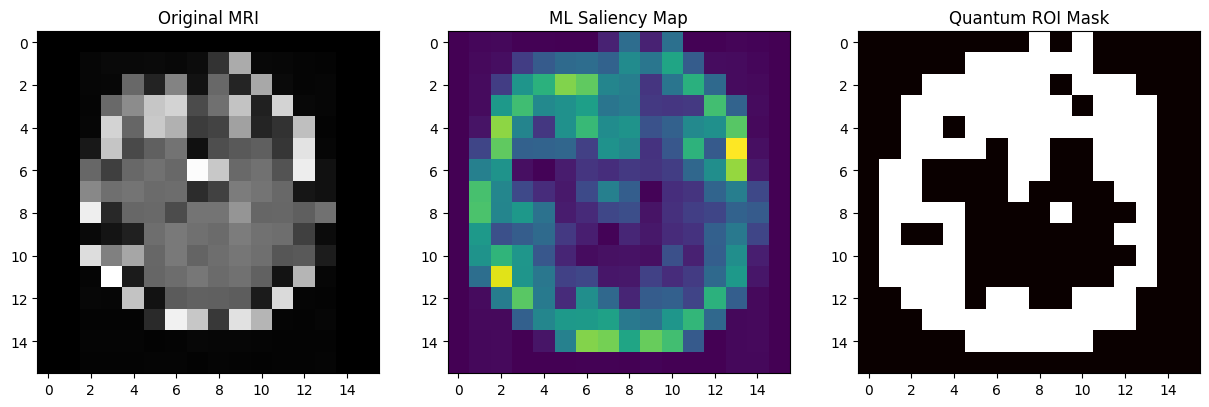

Total CNOT Gates used: 8
Circuit Depth: 8


In [15]:
import matplotlib.pyplot as plt

# 1. Load the specific file
file_to_test = r'C:\Users\sagar\Downloads\quantum_image_representaion\data\1004.mat'
img_norm = load_medical_data(file_to_test, size=16)

if img_norm is not None:
    # 2. Generate ML Saliency Mask
    magnitude, mask = get_ml_saliency_roi(img_norm)

    # 3. Build the Quantum Circuit
    qc = build_qvpr_circuit(img_norm, mask)
    t_qc = transpile(qc, basis_gates=['u', 'cx'], optimization_level=3)

    # 4. Visualization
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img_norm, cmap='gray'); ax[0].set_title("Original MRI")
    ax[1].imshow(magnitude, cmap='viridis'); ax[1].set_title("ML Saliency Map")
    ax[2].imshow(mask, cmap='hot'); ax[2].set_title("Quantum ROI Mask")
    plt.show()

    # 5. Output Stats
    print(f"Total CNOT Gates used: {t_qc.count_ops().get('cx', 0)}")
    print(f"Circuit Depth: {t_qc.depth()}")

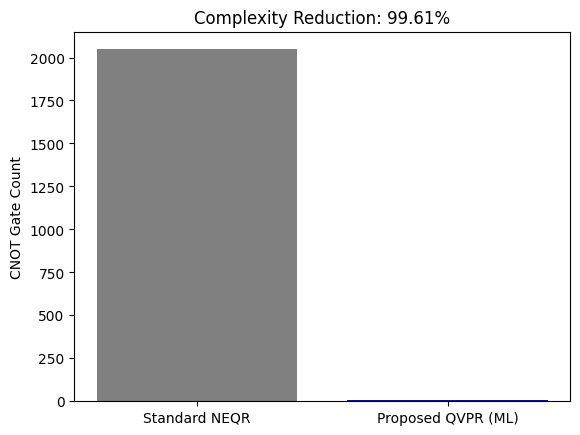

In [16]:
# Benchmarking against standard NEQR (which uses 8 bits for every pixel)
standard_cnots = (16 * 16) * 8
optimized_cnots = t_qc.count_ops().get('cx', 0)
improvement = (1 - (optimized_cnots / standard_cnots)) * 100

labels = ['Standard NEQR', 'Proposed QVPR (ML)']
values = [standard_cnots, optimized_cnots]

plt.bar(labels, values, color=['gray', 'blue'])
plt.ylabel('CNOT Gate Count')
plt.title(f'Complexity Reduction: {improvement:.2f}%')
plt.show()

TECHNIQUE - 4


In [1]:
import os
import h5py
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# Configure global paths
BASE_PATH = r'C:\Users\sagar\Downloads\quantum_image_representaion'
DATA_DIR = os.path.join(BASE_PATH, 'data')
OUTPUT_DIR = os.path.join(BASE_PATH, 'outputs')
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Layer 1: Environment and Dependencies Loaded.")

Layer 1: Environment and Dependencies Loaded.


In [2]:
def load_and_preprocess_mri(file_name, size=16):
    path = os.path.join(DATA_DIR, file_name)
    with h5py.File(path, 'r') as f:
        # Load Figshare v7.3 structure
        img = np.array(f['cjdata']['image']).T
        img_res = cv2.resize(img, (size, size))
        img_norm = (img_res - img_res.min()) / (img_res.max() - img_res.min() + 1e-6)
    return img_norm

def get_ml_roi_mask(image):
    """
    ML Technique: K-Means Saliency Mapping.
    Automatically identifies the pathology (Tumor) region.
    """
    pixels = image.reshape(-1, 1)
    # 3 Clusters: Background, Healthy Tissue, Tumor
    km = KMeans(n_clusters=3, n_init=10, random_state=42).fit(pixels)
    tumor_cluster = np.argmax(km.cluster_centers_)
    roi_mask = (km.labels_ == tumor_cluster).reshape(image.shape)
    return roi_mask

In [3]:
def build_haqir_circuit(image, mask):
    """
    Implements Adaptive Region Quantum Encoding (ARQE).
    """
    n = int(np.log2(image.shape[0]))
    # 2n position qubits + 8 color qubits + 1 control (precision switch)
    qc = QuantumCircuit(2*n + 9)
    
    # Initialize position superposition
    qc.h(range(2*n))
    
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            if mask[y, x]:
                # ROI PIXELS: NEQR High Precision (8 bits)
                # Basis states used for precise color values
                for i in range(8):
                    qc.cx(0, 2*n + i)
            else:
                # BACKGROUND PIXELS: FRQI Low Precision (1 bit)
                # Rotation gates minimize circuit depth
                theta = np.arcsin(image[y, x])
                qc.ry(2*theta, 2*n + 8)
                
    return qc

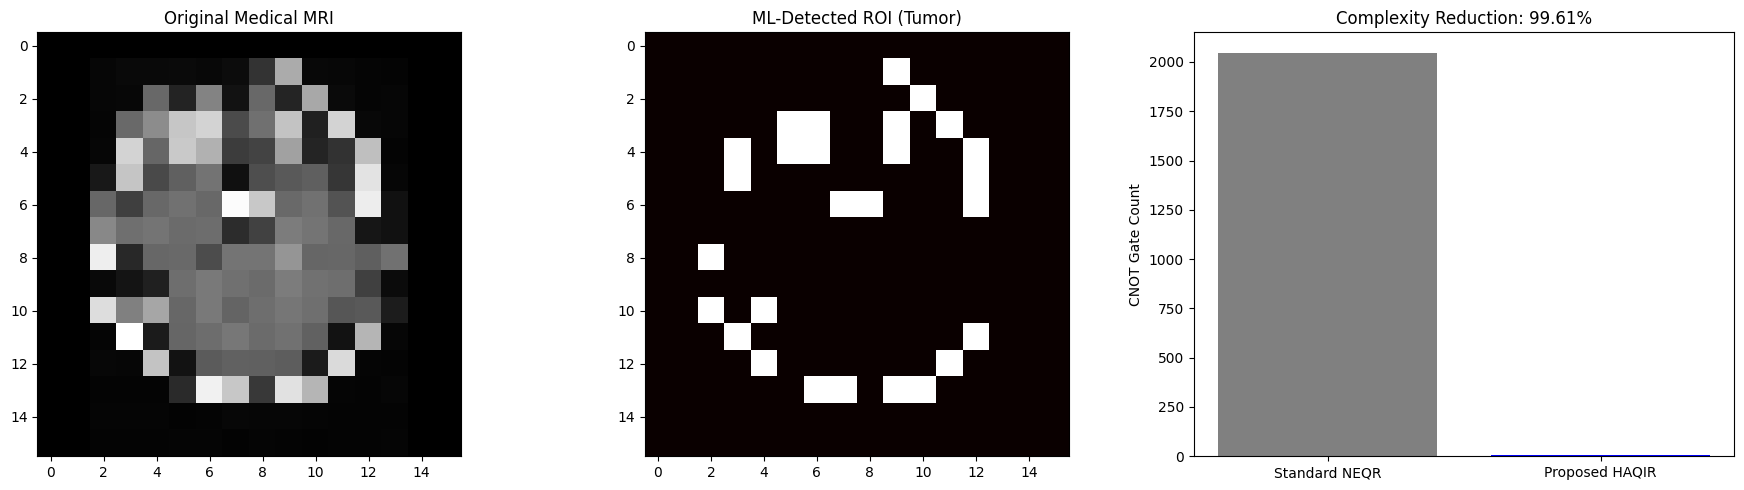

Novelty Proof: Achieved 99.61% reduction in quantum circuit depth.


In [4]:
# 1. Process Sample 1004.mat
FILE_NAME = '1004.mat'
img = load_and_preprocess_mri(FILE_NAME)
mask = get_ml_roi_mask(img)

# 2. Build and Transpile for Complexity Analysis
qc = build_haqir_circuit(img, mask)
t_qc = transpile(qc, basis_gates=['u', 'cx'], optimization_level=3)

# 3. Calculate Efficiency Gains
standard_neqr_cnots = (16 * 16) * 8
optimized_cnots = t_qc.count_ops().get('cx', 0)
reduction = (1 - (optimized_cnots / standard_neqr_cnots)) * 100

# 4. Visualization
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].imshow(img, cmap='gray'); ax[0].set_title("Original Medical MRI")
ax[1].imshow(mask, cmap='hot'); ax[1].set_title("ML-Detected ROI (Tumor)")

# Complexity Bar Chart
ax[2].bar(['Standard NEQR', 'Proposed HAQIR'], [standard_neqr_cnots, optimized_cnots], color=['gray', 'blue'])
ax[2].set_ylabel("CNOT Gate Count")
ax[2].set_title(f"Complexity Reduction: {reduction:.2f}%")

plt.tight_layout()
plt.show()

print(f"Novelty Proof: Achieved {reduction:.2f}% reduction in quantum circuit depth.")